In [ ]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install rdflib pandas scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install xgboost
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
%%writefile harrypotter_kg_ru.py
from __future__ import annotations

import argparse
import re
import time
import html
import urllib.parse
import requests
import logging
from pathlib import Path
from bs4 import BeautifulSoup
from unidecode import unidecode
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, OWL
from typing import Optional, Callable

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger("hp-kg")


BASE_IRI = "http://www.semanticweb.org/ekaterinakulesova/ontologies/2025/0/harry_potter#"
BASE = "https://harrypotter.fandom.com/ru/wiki/"
API_ENDPOINT = "https://harrypotter.fandom.com/ru/api.php"

REQUEST_DELAY = 0.2
RELATION_DELAY = 0.05

OUT_FILE = "harrypotter_kg_ru.ttl"
CHECKPOINT_EVERY = 120
_save_counter = 0

g = Graph()
HP = Namespace(BASE_IRI)
HPO = Namespace(BASE_IRI)
g.bind("hp", HP)
g.bind("hpo", HPO)
g.bind("rdfs", RDFS)
g.bind("owl", OWL)

def qn(term) -> str:
    try:
        if isinstance(term, URIRef) and str(term).startswith(BASE_IRI):
            return str(term).replace(BASE_IRI, "hpo:")
        return g.namespace_manager.normalizeUri(term)
    except Exception:
        return str(term)


def load_existing_graph(path: str):
    if not path:
        return
    file_path = Path(path)
    if not file_path.exists():
        logger.info("Файл %s не найден, создаём новый граф", file_path)
        return
    try:
        g.parse(file_path, format="turtle")
        logger.info("Загружено %s триплетов из %s", len(g), file_path)
    except Exception as exc:
        logger.warning("Не удалось загрузить %s: %s", file_path, exc)

classes = {
    "Thing": HPO.Thing,
    "Artifact": HPO.Artifact,
    "Character": HPO.Character,
    "Human": HPO.Human,
    "Muggle": HPO.Muggle,
    "Squib": HPO.Squib,
    "Wizard": HPO.Wizard,
    "Magical_creature": HPO.Magical_creature,
    "Centaur": HPO.Centaur,
    "Ghost": HPO.Ghost,
    "Giant": HPO.Giant,
    "Giant_spider": HPO.Giant_spider,
    "House": HPO.House,
    "House_elf": HPO.House_elf,
    "Mermaid": HPO.Mermaid,
    "Event": HPO.Event,
    "Big": HPO.Big,
    "Small": HPO.Small,
    "Location": HPO.Location,
    "Organization": HPO.Organization,
    "Potion": HPO.Potion,
    "Role": HPO.Role,
    "Spell": HPO.Spell,
}
for c, p in [
    (classes["Artifact"], classes["Thing"]),
    (classes["Character"], classes["Thing"]),
    (classes["Human"], classes["Character"]),
    (classes["Muggle"], classes["Human"]),
    (classes["Squib"], classes["Human"]),
    (classes["Wizard"], classes["Human"]),
    (classes["Magical_creature"], classes["Character"]),
    (classes["Centaur"], classes["Magical_creature"]),
    (classes["Ghost"], classes["Magical_creature"]),
    (classes["Giant"], classes["Magical_creature"]),
    (classes["Giant_spider"], classes["Magical_creature"]),
    (classes["House_elf"], classes["Magical_creature"]),
    (classes["Mermaid"], classes["Magical_creature"]),
    (classes["Event"], classes["Thing"]),
    (classes["Big"], classes["Event"]),
    (classes["Small"], classes["Event"]),
    (classes["House"], classes["Thing"]),
    (classes["Location"], classes["Thing"]),
    (classes["Organization"], classes["Thing"]),
    (classes["Potion"], classes["Thing"]),
    (classes["Role"], classes["Thing"]),
    (classes["Spell"], classes["Thing"]),
]:
    g.add((c, RDF.type, OWL.Class))
    g.add((c, RDFS.subClassOf, p))

obj_props = {
    "activeAt": HPO.activeAt,
    "artifactInvolvedIn": HPO.artifactInvolvedIn,
    "hasOwner": HPO.hasOwner,
    "hasCreator": HPO.hasCreator,
    "hasManufacturer": HPO.hasManufacturer,
    "friendWith": HPO.friendWith,
    "hasRole": HPO.hasRole,
    "memberOf": HPO.memberOf,
    "participatedIn": HPO.participatedIn,
    "relativeOf": HPO.relativeOf,
    "hasFather": HPO.hasFather,
    "hasMother": HPO.hasMother,
    "marriedWith": HPO.marriedWith,
    "romanceWith": HPO.romanceWith,
    "studiedAt": HPO.studiedAt,
    "takePartInEvent": HPO.takePartInEvent,
    "tookPlaceAt": HPO.tookPlaceAt,
    "hasSibling": HPO.hasSibling,
    "hasBrother": HPO.hasBrother,
    "hasSister": HPO.hasSister,
    "hasChild": HPO.hasChild,
    "hasSon": HPO.hasSon,
    "hasDaughter": HPO.hasDaughter,
    "hasUncle": HPO.hasUncle,
    "hasAunt": HPO.hasAunt,
    "hasNephew": HPO.hasNephew,
    "hasNiece": HPO.hasNiece,
    "hasGrandparent": HPO.hasGrandparent,
    "hasGrandchild": HPO.hasGrandchild,

    "siblingOf": HPO.siblingOf,
    "brotherOf": HPO.brotherOf,
    "sisterOf": HPO.sisterOf,
    "childOf": HPO.childOf,
    "sonOf": HPO.sonOf,
    "daughterOf": HPO.daughterOf,

    "godfatherOf": HPO.godfatherOf,
    "godsonOf": HPO.godsonOf,
    "cousinOf": HPO.cousinOf,
    "nephewOf": HPO.nephewOf,
    "nieceOf": HPO.nieceOf,
}

data_props = {
    "hasWand": HPO.hasWand,
    "hasPatronus": HPO.hasPatronus,
    "purpose": HPO.purpose,
    "hasType": HPO.hasType,
    "formula": HPO.formula,
    "effect": HPO.effect,
}

for p in data_props.values():
    g.add((p, RDF.type, OWL.DatatypeProperty))
for p in obj_props.values():
    g.add((p, RDF.type, OWL.ObjectProperty))
for p in ["godfatherOf", "godsonOf", "cousinOf", "nephewOf", "nieceOf", "hasManufacturer"]:
    g.add((obj_props[p], RDF.type, OWL.ObjectProperty))


session = requests.Session()
retry = Retry(
    total=4, backoff_factor=0.5,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"], raise_on_status=False,
)
adapter = HTTPAdapter(max_retries=retry)
session.mount("https://", adapter)
session.mount("http://", adapter)

def http_get(url: str) -> BeautifulSoup | None:
    try:
        r = session.get(url, headers={"User-Agent": "hp-kg-populator/1.0"}, timeout=20)
        if r.status_code == 200:
            return BeautifulSoup(r.text, "html.parser")
        logger.warning("HTTP %s: %s", r.status_code, url)
    except requests.RequestException as e:
        logger.warning("Ошибка запроса %s: %s", url, e)
    return None


def save_checkpoint(force=False):
    global _save_counter
    if not force and _save_counter < CHECKPOINT_EVERY:
        return
    g.serialize(destination=OUT_FILE, format="turtle")
    logger.info("Сохранено в %s (триплетов: %s)", OUT_FILE, len(g))
    _save_counter = 0

def bump_counter(n=1):
    global _save_counter
    _save_counter += n
    save_checkpoint(False)

SKIP_TITLE_PATTERNS = [
    r"\(персонажи\)$", r"\(персонаж\)$", r"\(персонажи фильма\)$",
    r"^Список($|[ \t])", r"^Персонажи($|[ \t])", r"^Категория:",
]
def should_skip_title(title: str) -> bool:
    if not title:
        return True
    t = title.strip()
    for pat in SKIP_TITLE_PATTERNS:
        if re.search(pat, t, flags=re.IGNORECASE):
            return True
    return False

def slugify(label: str) -> str:
    txt = html.unescape(label).strip()
    ascii_txt = unidecode(txt)
    ascii_txt = re.sub(r"[\s/]+", "_", ascii_txt)
    ascii_txt = re.sub(r"[^A-Za-z0-9_\-]", "", ascii_txt)
    return ascii_txt or "entity"

def hp_entity(s: str) -> URIRef:
    return HP[s]

def add_labeled_instance(uri: URIRef, label_ru: str, rdf_type: URIRef):
    already = (uri, RDF.type, None) in g
    g.add((uri, RDF.type, rdf_type))
    g.add((uri, RDFS.label, Literal(label_ru, lang="ru")))
    if not already:
        logger.info("%s ← %s (%s)", qn(rdf_type), label_ru, qn(uri))
        bump_counter()

def fandom_url(title_ru: str) -> str:
    return urllib.parse.urljoin(BASE, urllib.parse.quote(title_ru.replace(" ", "_")))

def parse_categories(soup: BeautifulSoup) -> set[str]:
    cats = set()
    for a in soup.select('.page-header__categories a.category[href^="/ru/wiki/Категория:"]'):
        t = (a.get("title") or a.get_text(strip=True) or "").strip()
        if t.startswith("Категория:"):
            cats.add(t.replace("Категория:", "").strip())
    for a in soup.select('#articleCategories a[href^="/ru/wiki/Категория:"]'):
        t = (a.get("title") or a.get_text(strip=True) or "").strip()
        if t.startswith("Категория:"):
            cats.add(t.replace("Категория:", "").strip())
    return cats

def parse_infobox(soup: BeautifulSoup) -> dict:
    data = {}
    box = soup.select_one(".portable-infobox")
    if not box:
        return data
    for row in box.select(".pi-data"):
        label = row.select_one(".pi-data-label")
        value = row.select_one(".pi-data-value")
        if not label or not value:
            continue
        key = label.get_text(separator=" ", strip=True)
        text = value.get_text(separator=" ", strip=True)
        links = []
        for a in value.select("a[href]"):
            href = a.get("href") or ""
            title = a.get("title") or a.get_text(strip=True)
            if href.startswith("/ru/wiki/") and title and "/Категория:" not in href:
                links.append(title)
        data[key] = {"text": text, "links": links}
    return data

def ensure_entity(title_ru: str, rdf_type: URIRef):
    uri = hp_entity(slugify(title_ru))
    add_labeled_instance(uri, title_ru, rdf_type)
    return uri

def link_by_titles(subject_uri: URIRef, prop: URIRef, titles: list[str], fallback_type: URIRef):
    for t in titles:
        if should_skip_title(t):
            continue
        obj = hp_entity(slugify(t))
        if (obj, RDF.type, None) not in g:
            add_labeled_instance(obj, t, fallback_type)
        g.add((subject_uri, prop, obj))


detect_type_cache: dict[str, Optional[URIRef]] = {}

def determine_type_for_title(title_ru: str) -> Optional[URIRef]:
    """
    Если в графе уже есть тип — возвращаем его.
    Иначе пробуем запросить страницу персонажа и вычислить тип через type_from_sources.
    Кешируем результаты в detect_type_cache, чтобы не делать лишних запросов.
    Возвращаем найденный класс или None, если не удалось определить.
    """
    if not title_ru:
        return None
    if title_ru in detect_type_cache:
        return detect_type_cache[title_ru]
    obj = hp_entity(slugify(title_ru))
    for _, _, t in g.triples((obj, RDF.type, None)):
        if isinstance(t, URIRef):
            detect_type_cache[title_ru] = t
            return t

    url = fandom_url(title_ru)
    soup = http_get(url)
    if not soup:
        detect_type_cache[title_ru] = None
        return None
    if not soup.select_one(".portable-infobox"):
        detect_type_cache[title_ru] = None
        return None
    info = parse_infobox(soup)
    cats = parse_categories(soup)
    page_text = " ".join(soup.stripped_strings)
    rdf_type = type_from_sources(info, cats, page_text)
    detect_type_cache[title_ru] = rdf_type
    return rdf_type


def link_people_analyze(subject_uri: URIRef, prop: URIRef, titles: list[str], fallback_type: URIRef):
    for t in titles:
        if should_skip_title(t):
            continue
        detected_type = determine_type_for_title(t)
        use_type = detected_type or fallback_type
        obj = hp_entity(slugify(t))
        if (obj, RDF.type, None) not in g:
            add_labeled_instance(obj, t, use_type)
        g.add((subject_uri, prop, obj))


FIELD_MAP = {
    "Дом": ("memberOf", classes["House"]),
    "Организация": ("memberOf", classes["Organization"]),
    "Принадлежность": ("memberOf", classes["Organization"]),

    "Место обучения": ("studiedAt", classes["Location"]),
    "Обучался в": ("studiedAt", classes["Location"]),
    "Школа": ("studiedAt", classes["Location"]),
    "Учился в": ("studiedAt", classes["Location"]),

    "Род занятий": ("hasRole", classes["Role"]),
    "Профессия": ("hasRole", classes["Role"]),
    "Должность": ("hasRole", classes["Role"]),
    "Специальность": ("hasRole", classes["Role"]),

    "Супруг": ("marriedWith", classes["Character"]),
    "Супруга": ("marriedWith", classes["Character"]),
    "Супруг(а)": ("marriedWith", classes["Character"]),
    "Отец": ("hasFather", classes["Character"]),
    "Мать": ("hasMother", classes["Character"]),
    "Родители": ("hasParent", classes["Character"]),
    "Друзья": ("friendWith", classes["Character"]),
    "Любовный интерес": ("romanceWith", classes["Character"]),
    "Романтические отношения": ("romanceWith", classes["Character"]),

    "Семья": ("family_from_infobox", classes["Character"]),
    "Брат": ("hasBrother", classes["Character"]),
    "Сестра": ("hasSister", classes["Character"]),
    "Братья": ("hasSibling", classes["Character"]),
    "Сёстры": ("hasSibling", classes["Character"]),
    "Братья и сёстры": ("hasSibling", classes["Character"]),
    "Дети": ("hasChild", classes["Character"]),
    "Сын": ("hasSon", classes["Character"]),
    "Дочь": ("hasDaughter", classes["Character"]),
    "Сыновья": ("hasChild", classes["Character"]),
    "Дочери": ("hasChild", classes["Character"]),
    "Дядя": ("hasUncle", classes["Character"]),
    "Тётя": ("hasAunt", classes["Character"]),
    "Племянник": ("hasNephew", classes["Character"]),
    "Племянница": ("hasNiece", classes["Character"]),
    "Дедушка": ("hasGrandparent", classes["Character"]),
    "Бабушка": ("hasGrandparent", classes["Character"]),
    "Внук": ("hasGrandchild", classes["Character"]),
    "Внучка": ("hasGrandchild", classes["Character"]),

    "Вид": ("type_hint", None),
    "Вид(ы)": ("type_hint", None),
    "Раса": ("type_hint", None),
    "Раса/вид": ("type_hint", None),
    "Принадлежность к виду": ("type_hint", None),
    "Пол": ("sex_hint", None),

    "Чистота крови": ("blood_status_hint", None),
}

CATEGORY_TO_CLASS = {
    "Люди": classes["Human"],
    "Маги": classes["Wizard"],
    "Маги по алфавиту": classes["Wizard"],
    "Магглы": classes["Muggle"],
    "Сквибы": classes["Squib"],
    "Маглорождённые волшебники": classes["Wizard"],
    "Чистокровные волшебники": classes["Wizard"],
    "Полукровки": classes["Wizard"],
    "Домовые эльфы": classes["House_elf"],
    "Привидения": classes["Ghost"],
    "Кентавры": classes["Centaur"],
    "Акромантулы": classes["Giant_spider"],
    "Великаны": classes["Giant"],
    "Русалки": classes["Mermaid"],
}

CREATURE_KEYWORDS = {
    "кентавр": classes["Centaur"],
    "привидение": classes["Ghost"],
    "гигант": classes["Giant"],
    "акромантул": classes["Giant_spider"],
    "домовой эльф": classes["House_elf"],
    "русалк": classes["Mermaid"],
}

def has_word(txt: str, pattern: str) -> bool:
    try:
        return re.search(rf"(?iu)\b{pattern}\w*\b", txt) is not None
    except re.error:
        patt = re.escape(pattern)
        return re.search(rf"(?iu)\b{patt}\w*\b", txt) is not None

def choose_most_specific(types: list[URIRef]) -> URIRef:
    priority = [
        classes["Centaur"], classes["Ghost"], classes["Giant"], classes["Giant_spider"],
        classes["House_elf"], classes["Mermaid"],
        classes["Wizard"], classes["Muggle"], classes["Squib"],
        classes["Human"], classes["Character"],
    ]
    for cls in priority:
        if cls in types:
            return cls
    return classes["Character"]


def type_from_sources(info: dict, cats: set[str], page_text: str) -> URIRef:
    """
    Определение типа сущности по инфобоксу, категориям и тексту.
    Приоритет:
      1. Явные указания вида (кентавр, призрак и т.д.)
      2. Поле «Чистота крови» (даже для не-людей!)
      3. Поле «Вид» → человек/маг/существо
      4. Категории (особенно «Магглы», «Сквибы»)
      5. Контекст (осторожно: «Хогвартс» у магглов — не делает их волшебниками)
    """

    def classify_by_purity() -> Optional[URIRef]:
        purity = (info.get("Чистота крови", {}) or {}).get("text", "")
        purity = purity.lower().strip()
        if not purity:
            return None
        if has_word(purity, "сквиб"):
            return classes["Squib"]
        if has_word(purity, "маглорожд") or has_word(purity, "полукров"):
            return classes["Wizard"]
        if has_word(purity, "магл") and not has_word(purity, "маглорожд"):
            return classes["Muggle"]
        if any(has_word(purity, s) for s in ["чистокровный", "грязнокров", "кровь"]):
            return classes["Wizard"]
        return None

    raw_kind = ""
    for k in ("Вид", "Вид(ы)", "Раса", "Раса/вид", "Принадлежность к виду"):
        if k in info:
            raw_kind = info[k]["text"].lower().strip()
            break

    if raw_kind:
        for key, cls in CREATURE_KEYWORDS.items():
            if key in raw_kind:
                return cls
        if "привидение" in raw_kind or "призрак" in raw_kind:
            return classes["Ghost"]
        if "великан" in raw_kind:
            return classes["Giant"]
        if "акромантул" in raw_kind:
            return classes["Giant_spider"]
        if "домовой эльф" in raw_kind or ("домовой" in raw_kind and "эльф" in raw_kind):
            return classes["House_elf"]
        if "русалк" in raw_kind:
            return classes["Mermaid"]
        if "волшебник" in raw_kind or "маг" in raw_kind:
            return classes["Wizard"]
        if "человек" in raw_kind:
            by_purity = classify_by_purity()
            if by_purity:
                return by_purity
            if "Дом" in info:
                house = info["Дом"]["text"].lower()
                if any(h in house for h in ["гриффиндор", "слизерин", "когтевран", "пуффендуй"]):
                    return classes["Wizard"]
            if "обучался" in page_text.lower() or "хогвартс" in page_text.lower() and "учился" in page_text.lower():
                return classes["Wizard"]
            return classes["Human"]

    by_purity = classify_by_purity()
    if by_purity:
        return by_purity
    for c in cats:
        if c in CATEGORY_TO_CLASS:
            return CATEGORY_TO_CLASS[c]
        if "сквиб" in c.lower():
            return classes["Squib"]
        if "маггл" in c.lower() or "мугл" in c.lower():
            return classes["Muggle"]
        if any(x in c.lower() for x in ["хогвартс", "маг", "волшебник", "ученик", "профессор"]):
            pass

    txt = page_text.lower()

    muggle_phrases = [
        "не маг", "немаг", "маггл", "мугл", "muggle", "non-mag",
        "не волшебник", "обычный человек", "простой человек",
        "не имеет магических способностей", "не обучался в хогвартсе",
        "не владеет магией"
    ]
    for phrase in muggle_phrases:
        if phrase in txt:
            if "сквиб" in txt:
                return classes["Squib"]
            return classes["Muggle"]

    if ("хогвартс" in txt and ("учился" in txt or "посещал" in txt or "выпускник" in txt)) \
       or "палочка" in txt \
       or "заклин" in txt \
       or "волшебник" in txt \
       or "маги" in txt \
       or "чары" in txt:
        return classes["Wizard"]

    for key, cls in CREATURE_KEYWORDS.items():
        if has_word(txt, key):
            return cls

    return classes["Human"]

def extract_family_relations_from_text(soup: BeautifulSoup, subject_title: str) -> list[tuple[str, str]]:

    relations = []

    content = soup.select_one(".mw-parser-output")
    if not content:
        return relations

    text_blocks = []
    for elem in content.children:
        if elem.name in {"p", "ul", "ol", "h2", "h3"}:
            text_blocks.append(elem.get_text(separator=" ", strip=True))

    full_text = " ".join(text_blocks)

    patterns = [
        ("hasBrother", r"(?:брат(?:а|у|ом)?|брат\s+его|его\s+брат)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("hasSister", r"(?:сестр(?:а|ы|у|ой)?|сестра\s+его|его\s+сестра)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("hasSon", r"(?:сын(?:а|у|ом)?|его\s+сын)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("hasDaughter", r"(?:дочь|дочер(?:и|ью)?|его\s+дочь)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("hasFather", r"(?:отец|его\s+отец)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("hasMother", r"(?:мать|его\s+мать)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
        ("marriedWith", r"(?:супруг(?:а|и)?|муж|жена|женат\s+на|замужем\s+за)\s+—?\s*([А-ЯЁ][а-яё\s\-]+?(?:\s[А-ЯЁ]\.)?)"),
    ]

    for rel_type, pattern in patterns:
        for match in re.finditer(pattern, full_text, flags=re.IGNORECASE | re.UNICODE):
            name_candidate = match.group(1).strip()
            name_candidate = re.sub(r"[,\.!\?;:]+$", "", name_candidate)
            name_candidate = re.sub(r"\s+(?:и|или|также|ранее|позже)\s+.*$", "", name_candidate)
            if name_candidate and not should_skip_title(name_candidate):
                if len(name_candidate.split()) >= 2 and re.match(r"^[А-ЯЁ][а-яё]+(?:\s+[А-ЯЁ][а-яё]+)+$", name_candidate):
                    relations.append((rel_type, name_candidate))


    return relations


def parse_family_section(soup: BeautifulSoup) -> list[tuple[str, str]]:
    relations = []

    family_header = None
    for h2 in soup.select("h2"):
        if "семья" in h2.get_text(strip=True).lower():
            family_header = h2
            break

    if not family_header:
        return relations

    next_elem = family_header.find_next_sibling()
    family_text = ""
    while next_elem and next_elem.name != "h2":
        if next_elem.name in {"p", "ul", "ol"}:
            family_text += " " + next_elem.get_text(separator=" ", strip=True)
        next_elem = next_elem.find_next_sibling()

    if not family_text.strip():
        return relations

    items = [item.strip() for item in re.split(r"[,;]", family_text)]

    role_map = {
        "отец": "hasFather",
        "мать": "hasMother",
        "брат": "hasBrother",
        "сестра": "hasSister",
        "сын": "hasSon",
        "дочь": "hasDaughter",
        "дядя": "hasUncle",
        "тётя": "hasAunt",
        "племянник": "hasNephew",
        "племянница": "hasNiece",
        "дедушка": "hasGrandparent",
        "бабушка": "hasGrandparent",
        "внук": "hasGrandchild",
        "внучка": "hasGrandchild",
        "кузина": "cousinOf",
        "кузен": "cousinOf",
        "двоюродная племянница": "nieceOf",
        "двоюродный племянник": "nephewOf",
        "троюродный племянник": "nephewOf",
        "крестник": "godsonOf",
        "крёстный отец": "godfatherOf",
    }

    for item in items:
        item = re.sub(r"[†*«»\"]", "", item).strip()
        if not item:
            continue

        match = re.match(r"([А-ЯЁ][а-яё\s\-]+?)\s*\(([^)]+)\)", item)
        if not match:
            continue

        name = match.group(1).strip()
        role_desc = match.group(2).strip().lower()

        for role_name, prop_key in role_map.items():
            if role_name in role_desc:
                relations.append((prop_key, name))
                break

    return relations


def parse_family_field_from_infobox(family_text: str) -> list[tuple[str, str]]:

    logger.debug("🔍 Разбор поля 'Семья': %r", family_text[:200])
    relations = []

    cleaned_text = re.sub(r"[\†*«»\"]|\[\s*\d+\s*\]", "", family_text).strip()
    if not cleaned_text:
        return relations

    role_map = {
        "отец": "hasFather", "свёкор": "hasFather", "тесть": "hasFather",
        "мать": "hasMother", "свекровь": "hasMother", "тёща": "hasMother",
        "брат": "hasBrother", "деверь": "hasBrother", "шурин": "hasBrother",
        "сестра": "hasSister", "золовка": "hasSister",
        "сын": "hasSon",
        "дочь": "hasDaughter",
        "дядя": "hasUncle",
        "тётя": "hasAunt",
        "племянник": "hasNephew", "внучатый племянник": "hasNephew",
        "племянница": "hasNiece",
        "дед": "hasGrandparent", "дедушка": "hasGrandparent",
        "бабушка": "hasGrandparent",
        "внук": "hasGrandchild",
        "внучка": "hasGrandchild",
        "жена": "marriedWith", "супруга": "marriedWith",
        "муж": "marriedWith", "супруг": "marriedWith",
        "кузина": "cousinOf", "двоюродная сестра": "cousinOf",
        "кузен": "cousinOf", "двоюродный брат": "cousinOf",
        "крестник": "godsonOf",
        "крёстный отец": "godfatherOf",
        "зять": "sonOf",
        "невестка": "daughterOf",
        "предок": "relativeOf",
        "потомок": "relativeOf",
    }

    pattern = re.compile(r"([А-ЯЁ][^()]+?)\s*\(([^)]+)\)")

    for match in pattern.finditer(cleaned_text):
        name = match.group(1).strip()
        role_desc = match.group(2).strip().lower()

        if len(name) < 2 or should_skip_title(name):
            continue

        found_role = False
        sorted_roles = sorted(role_map.keys(), key=len, reverse=True)
        for role_name in sorted_roles:
            if re.search(rf"\b{re.escape(role_name)}\b", role_desc):
                prop_key = role_map[role_name]
                relations.append((prop_key, name))
                found_role = True
                break

        if not found_role:
            for role_name, prop_key in role_map.items():
                if role_name in role_desc:
                    relations.append((prop_key, name))
                    break

    return relations


def scrape_character(title_ru: str):
    if should_skip_title(title_ru):
        return
    url = fandom_url(title_ru)
    soup = http_get(url)
    if not soup:
        logger.warning("Пропуск (нет доступа): %s", title_ru)
        return

    if not soup.select_one(".portable-infobox"):
        logger.debug("Пропуск (нет инфобокса): %s", title_ru)
        return

    info = parse_infobox(soup)
    cats = parse_categories(soup)
    rdf_type = type_from_sources(info, cats, soup.get_text(separator=" ", strip=True))
    subj = ensure_entity(title_ru, rdf_type)

    if "Пол" in info:
        g.add((subj, RDFS.comment, Literal(f"Пол: {info['Пол']['text']}", lang="ru")))

    direct_fields_map = {
        "Факультет": ("facultet", obj_props["memberOf"], "object"),
        "Палочка": ("wand", data_props["hasWand"], "data"),
        "Патронус": ("patronus", data_props["hasPatronus"], "data"),
        "Работа": ("job", obj_props["hasRole"], "role"),
    }

    for info_key, (log_key, prop_uri, prop_type) in direct_fields_map.items():
        if info_key in info:
            value_text = info[info_key].get("text", "").strip()
            if not value_text:
                continue

            if info_key == "Факультет" and rdf_type != classes["Wizard"]:
                continue

            if prop_type == "data":
                g.add((subj, prop_uri, Literal(value_text, lang="ru")))
            elif prop_type == "object":
                if value_text in HOUSES:
                    obj_uri = ensure_entity(value_text, classes["House"])
                    g.add((subj, prop_uri, obj_uri))
                else:
                    continue
            elif prop_type == "role":
                obj_uri = ensure_entity(value_text, classes["Role"])
                g.add((subj, prop_uri, obj_uri))

            logger.info(f"hpo:{log_key} {title_ru} -> {value_text}")
            bump_counter()

    logger.debug("Инфобокс для %s: %s", title_ru, list(info.keys()))
    for key, val in info.items():
        if key not in FIELD_MAP:
            continue
        prop_key, fallback_cls = FIELD_MAP[key]

        if prop_key == "family_from_infobox":
            if val["text"]:
                family_rels = parse_family_field_from_infobox(val["text"])
                for rel_type, person_title in family_rels:
                    if rel_type in obj_props:
                        prop_uri = obj_props[rel_type]
                        detected_type = determine_type_for_title(person_title)
                        use_type = detected_type or classes["Character"]
                        obj = ensure_entity(person_title, use_type)
                        g.add((subj, prop_uri, obj))
                        logger.info("👨‍👩‍👧‍👦 Инфобокс-Семья: %s --%s--> %s", title_ru, rel_type, person_title)
                        bump_counter()
            continue

        if prop_key in ("type_hint", "sex_hint", "blood_status_hint") or prop_key not in obj_props:
            continue
        prop_uri = obj_props[prop_key]

        PERSON_RELATIONS = {"marriedWith", "hasFather", "hasMother", "friendWith",
                            "romanceWith", "relativeOf", "hasParent"}
        if prop_key in PERSON_RELATIONS:
            if prop_key == "hasParent" and val["links"]:
                for link_title in val["links"]:
                    if any(link_title.endswith(end) for end in ["а", "я", "ия", "ина", "ьна", "на"]):
                        g.add((subj, obj_props["hasMother"], hp_entity(slugify(link_title))))
                    else:
                        g.add((subj, obj_props["hasFather"], hp_entity(slugify(link_title))))
                    detected = determine_type_for_title(link_title)
                    use_type = detected or classes["Character"]
                    ensure_entity(link_title, use_type)
                    logger.info("👨‍👦 Родитель: %s --%s--> %s", title_ru,
                                "hasMother" if "а" in link_title[-1] else "hasFather", link_title)
                continue
            if val["links"]:
                link_people_analyze(subj, prop_uri, val["links"], fallback_cls)
            else:
                v = val["text"]
                if not v or should_skip_title(v):
                    continue
                detected = determine_type_for_title(v)
                use_type = detected or fallback_cls
                obj = ensure_entity(v, use_type)
                g.add((subj, prop_uri, obj))
            continue

        if val["links"]:
            link_by_titles(subj, prop_uri, val["links"], fallback_cls)
        else:
            v = val["text"]
            if not v or should_skip_title(v):
                continue
            obj = ensure_entity(v, fallback_cls)
            g.add((subj, prop_uri, obj))

    family_section_rels = parse_family_section(soup)
    for prop_key, person_title in family_section_rels:
        if prop_key in obj_props:
            prop_uri = obj_props[prop_key]
            detected_type = determine_type_for_title(person_title)
            use_type = detected_type or classes["Character"]
            obj = ensure_entity(person_title, use_type)
            g.add((subj, prop_uri, obj))
            if prop_key == "hasFather":
                g.add((obj, obj_props["childOf"], subj))
            elif prop_key == "hasMother":
                g.add((obj, obj_props["childOf"], subj))
            elif prop_key == "hasBrother":
                g.add((obj, obj_props["brotherOf"], subj))
            elif prop_key == "hasSister":
                g.add((obj, obj_props["sisterOf"], subj))
            elif prop_key == "cousinOf":
                g.add((obj, obj_props["cousinOf"], subj))
            elif prop_key == "godsonOf":
                g.add((obj, obj_props["godfatherOf"], subj))
            elif prop_key == "godfatherOf":
                g.add((obj, obj_props["godsonOf"], subj))
            logger.info("Семья: %s --%s--> %s", title_ru, prop_key, person_title)
            bump_counter()

    family_rels = extract_family_relations_from_text(soup, title_ru)
    for rel_type, person_title in family_rels:
        if rel_type in obj_props:
            prop_uri = obj_props[rel_type]
            detected_type = determine_type_for_title(person_title)
            use_type = detected_type or classes["Character"]
            obj = hp_entity(slugify(person_title))
            if (obj, RDF.type, None) not in g:
                add_labeled_instance(obj, person_title, use_type)
            g.add((subj, prop_uri, obj))
            logger.info("🔗 Текст: %s --%s--> %s", title_ru, rel_type, person_title)
            bump_counter()


ARTIFACT_FIELD_MAP = {
    "Владелец": ("hasOwner", classes["Thing"]),
    "Владельцы": ("hasOwner", classes["Thing"]),
    "Хозяин": ("hasOwner", classes["Thing"]),
    "Создатель": ("hasCreator", classes["Thing"]),
    "Создатели": ("hasCreator", classes["Thing"]),
    "Изобретатель": ("hasCreator", classes["Thing"]),
    "Изобретатели": ("hasCreator", classes["Thing"]),
    "Производитель": ("hasManufacturer", classes["Thing"]),
    "Производители": ("hasManufacturer", classes["Thing"]),
    "Изготовитель": ("hasManufacturer", classes["Thing"]),
    "Изготовители": ("hasManufacturer", classes["Thing"]),
    "Назначение": ("purpose", None),
    "Предназначение": ("purpose", None),
    "Использование": ("purpose", None),
}


def scrape_artifact(title_ru: str) -> bool:
    if should_skip_title(title_ru):
        return False
    subj = ensure_entity(title_ru, classes["Artifact"])
    url = fandom_url(title_ru)
    soup = http_get(url)
    if not soup:
        logger.warning("Пропуск артефакта (нет доступа): %s", title_ru)
        return True
    info = parse_infobox(soup)
    if not info:
        return True

    for key, val in info.items():
        if key not in ARTIFACT_FIELD_MAP:
            continue
        prop_key, fallback_cls = ARTIFACT_FIELD_MAP[key]
        if prop_key == "purpose":
            text = val.get("text", "").strip()
            if text:
                g.add((subj, data_props["purpose"], Literal(text, lang="ru")))
                logger.info("🎯 Назначение: %s -> %s", title_ru, text)
                bump_counter()
            continue
        if prop_key not in obj_props:
            continue
        prop_uri = obj_props[prop_key]
        fallback = fallback_cls or classes["Thing"]
        added = False
        if val["links"]:
            link_by_titles(subj, prop_uri, val["links"], fallback)
            added = True
        else:
            text = val.get("text", "").strip()
            if text and not should_skip_title(text):
                obj = ensure_entity(text, fallback)
                g.add((subj, prop_uri, obj))
                added = True
        if added:
            logger.info("🔧 Артефакт: %s --%s--> %s", title_ru, prop_key, val.get("text", ""))
            bump_counter()
    return True


SPELL_FIELD_MAP = {
    "Тип": "hasType",
    "Вид": "hasType",
    "Вид магии": "hasType",
    "Ветвь магии": "hasType",
    "Категория": "hasType",
    "Инкарнация": "formula",
    "Формула": "formula",
    "Слова": "formula",
    "Эффект": "effect",
    "Воздействие": "effect",
    "Описание": "effect",
}


POTION_FIELD_MAP = {
    "Создатель": "hasCreator",
    "Создатели": "hasCreator",
    "Изобретатель": "hasCreator",
    "Изобретательница": "hasCreator",
    "Изобретатели": "hasCreator",
    "Производитель": "hasManufacturer",
    "Производители": "hasManufacturer",
    "Изготовитель": "hasManufacturer",
    "Изготовители": "hasManufacturer",
    "Эффект": "effect",
    "Воздействие": "effect",
    "Описание": "effect",
}


def scrape_spell(title_ru: str) -> bool:
    if should_skip_title(title_ru):
        return False
    subj = ensure_entity(title_ru, classes["Spell"])
    url = fandom_url(title_ru)
    soup = http_get(url)
    if not soup:
        logger.warning("Пропуск заклинания (нет доступа): %s", title_ru)
        return True
    info = parse_infobox(soup)
    if not info:
        return True

    for key, val in info.items():
        prop_key = SPELL_FIELD_MAP.get(key)
        if not prop_key or prop_key not in data_props:
            continue
        text_parts = []
        if val.get("links"):
            text_parts.extend([t.strip() for t in val["links"] if t and not should_skip_title(t)])
        raw_text = val.get("text", "").strip()
        if raw_text:
            text_parts.append(raw_text)
        text_parts = [t for t in text_parts if t]
        if not text_parts:
            continue
        literal_text = "; ".join(dict.fromkeys(text_parts))
        g.add((subj, data_props[prop_key], Literal(literal_text, lang="ru")))
        logger.info("✨ Заклинание: %s --%s--> %s", title_ru, prop_key, literal_text)
        bump_counter()
    return True


def scrape_potion(title_ru: str) -> bool:
    if should_skip_title(title_ru):
        return False
    subj = ensure_entity(title_ru, classes["Potion"])
    url = fandom_url(title_ru)
    soup = http_get(url)
    if not soup:
        logger.warning("Пропуск зелья (нет доступа): %s", title_ru)
        return True
    info = parse_infobox(soup)
    if not info:
        return True

    for key, val in info.items():
        prop_key = POTION_FIELD_MAP.get(key)
        if not prop_key:
            continue
        if prop_key in obj_props:
            fallback = classes["Thing"]
            added = False
            if val.get("links"):
                link_by_titles(subj, obj_props[prop_key], val["links"], fallback)
                added = True
            else:
                text = val.get("text", "").strip()
                if text and not should_skip_title(text):
                    obj = ensure_entity(text, fallback)
                    g.add((subj, obj_props[prop_key], obj))
                    added = True
            if added:
                logger.info("🧪 Зелье (obj): %s --%s--> %s", title_ru, prop_key, val.get("text", ""))
                bump_counter()
        elif prop_key in data_props:
            text = val.get("text", "").strip()
            if text:
                g.add((subj, data_props[prop_key], Literal(text, lang="ru")))
                logger.info("🧪 Зелье: %s --%s--> %s", title_ru, prop_key, text)
                bump_counter()
    return True


def scrape_single_page_as(label_ru: str, rdf_type: URIRef):
    if should_skip_title(label_ru):
        return
    ensure_entity(label_ru, rdf_type)

category_prefix_cache: dict[str, list[str]] = {}


def fetch_categories_by_prefix(prefix: str, limit: int = 20) -> list[str]:
    """
    Возвращает список существующих категорий, начинающихся с указанного префикса.
    """
    if not prefix:
        return []
    prefix = prefix.strip()
    if not prefix:
        return []
    if prefix in category_prefix_cache:
        return category_prefix_cache[prefix]

    params = {
        "action": "query",
        "format": "json",
        "list": "allcategories",
        "acprefix": prefix,
        "aclimit": limit,
        "acprop": "size",
    }
    try:
        resp = session.get(API_ENDPOINT, params=params, timeout=20)
        if resp.status_code != 200:
            logger.debug("Не удалось получить категории с префиксом %s (HTTP %s)", prefix, resp.status_code)
            category_prefix_cache[prefix] = []
            return []
        data = resp.json()
        cats = [c.get("*") for c in data.get("query", {}).get("allcategories", []) if c.get("*")]
        category_prefix_cache[prefix] = cats
        return cats
    except (requests.RequestException, ValueError) as exc:
        logger.debug("Ошибка получения категорий по префиксу %s: %s", prefix, exc)
        category_prefix_cache[prefix] = []
        return []


def _iter_category_members_api(category_title_ru: str, cap: int | None = None, include_subcategories: bool = False):
    seen_titles: set[str] = set()
    seen_categories: set[str] = set()
    queue = [_cleanup_category_title(category_title_ru)]
    total = 0

    headers = {"User-Agent": "hp-kg-populator/1.0"}

    while queue:
        current_cat = queue.pop(0)
        if not current_cat or current_cat in seen_categories:
            continue
        seen_categories.add(current_cat)

        cmcontinue = None
        while True:
            params = {
                "action": "query",
                "format": "json",
                "list": "categorymembers",
                "cmlimit": 500,
                "cmtitle": f"Категория:{current_cat}",
                "cmprop": "title|type|ids",
                "cmnamespace": "0|14",
            }
            if cmcontinue:
                params["cmcontinue"] = cmcontinue
            try:
                resp = session.get(API_ENDPOINT, params=params, headers=headers, timeout=20)
                if resp.status_code != 200:
                    logger.warning("Категория API HTTP %s: %s", resp.status_code, current_cat)
                    return
                data = resp.json()
            except (requests.RequestException, ValueError) as exc:
                logger.warning("Ошибка API категории %s: %s", current_cat, exc)
                return

            members = data.get("query", {}).get("categorymembers", [])
            for member in members:
                title = (member.get("title") or "").strip()
                if not title:
                    continue
                ns = member.get("ns")
                if ns == 14:
                    if include_subcategories:
                        sub_title = _cleanup_category_title(title)
                        if sub_title and sub_title not in seen_categories:
                            queue.append(sub_title)
                    continue
                if should_skip_title(title) or title in seen_titles:
                    continue
                seen_titles.add(title)
                yield title
                total += 1
                if cap and total >= cap:
                    return

            cmcontinue = data.get("continue", {}).get("cmcontinue")
            if not cmcontinue:
                break


def _cleanup_category_title(title: str | None) -> str:
    if not title:
        return ""
    cleaned = title.strip()
    for prefix in ("Категория:", "Category:"):
        if cleaned.startswith(prefix):
            cleaned = cleaned[len(prefix):]
    return cleaned.strip()


def _extract_category_name(href: str, fallback: str | None = None) -> Optional[str]:
    candidate = urllib.parse.unquote(href or "")
    marker_pos = -1
    for marker in ("/Категория:", "/Category:"):
        marker_pos = candidate.find(marker)
        if marker_pos != -1:
            candidate = candidate[marker_pos + len(marker):]
            break
    else:
        candidate = fallback or ""
    candidate = candidate.replace("_", " ")
    candidate = _cleanup_category_title(candidate)
    return candidate or None
def _iter_category_members_html(category_title_ru: str, cap: int | None = None, include_subcategories: bool = False):
    seen_titles: set[str] = set()
    seen_categories: set[str] = set()
    queue = [_cleanup_category_title(category_title_ru)]
    total = 0

    while queue:
        current_cat = queue.pop(0)
        if not current_cat:
            continue
        if current_cat in seen_categories:
            continue
        seen_categories.add(current_cat)

        url = fandom_url("Категория:" + current_cat)
        while url:
            soup = http_get(url)
            if not soup:
                break
            for a in soup.select("a.category-page__member-link"):
                href = a.get("href") or ""
                title = (a.get("title") or a.get_text(strip=True) or "").strip()
                if not title:
                    continue
                if "/Категория:" in href or "/Category:" in href:
                    if include_subcategories:
                        sub_title = _extract_category_name(href, title)
                        if sub_title and sub_title not in seen_categories:
                            queue.append(sub_title)
                    continue
                if should_skip_title(title) or title in seen_titles:
                    continue
                seen_titles.add(title)
                yield title
                total += 1
                if cap and total >= cap:
                    return
            next_a = soup.select_one('a.category-page__pagination-next')
            url = next_a["href"] if (next_a and next_a.get("href")) else None
            if url and url.startswith("/"):
                url = urllib.parse.urljoin(BASE, url)


def iter_category_members(category_title_ru: str, cap: int | None = None, include_subcategories: bool = False):
    yielded_any = False
    for title in _iter_category_members_api(category_title_ru, cap=cap, include_subcategories=include_subcategories):
        yielded_any = True
        yield title
    if yielded_any:
        return
    logger.info("API не вернул элементы категории %s, резервный HTML-парсинг", category_title_ru)
    for title in _iter_category_members_html(category_title_ru, cap=cap, include_subcategories=include_subcategories):
        yield title

def scrape_category_characters(category_title_ru: str, cap: int, delay: float = 0.2):
    logger.info("Категория персонажей: %s (cap=%s)", category_title_ru, cap)
    for title in iter_category_members(category_title_ru, cap=cap):
        scrape_character(title)
        ##time.sleep(delay)

def scrape_category_entities(
    category_title_ru: str,
    rdf_type: URIRef,
    cap: int,
    delay: float = 0.1,
    include_subcategories: bool = False,
) -> int:
    logger.info(
        "Категория сущностей: %s → %s (cap=%s, subcats=%s)",
        category_title_ru,
        qn(rdf_type),
        cap,
        include_subcategories,
    )
    produced = 0
    handler = ENTITY_TYPE_HANDLERS.get(rdf_type)
    for title in iter_category_members(
        category_title_ru, cap=cap, include_subcategories=include_subcategories
    ):
        if handler:
            if handler(title):
                produced += 1
        else:
            ensure_entity(title, rdf_type)
            produced += 1
        ##time.sleep(delay)
    return produced

CHAR_SEED = [
    "Гарри Поттер","Гермиона Грейнджер","Рон Уизли","Альбус Дамблдор","Северус Снегг",
    "Драко Малфой","Рубеус Хагрид","Минерва Макгонагалл","Сириус Блэк","Лорд Волан-де-Морт",
]
MUGGLE_SEED = [
    "Вернон Дурсль", "Петуния Дурсль", "Дадли Дурсль",
    "Мардж Дурсль",  "Флетчер", "Франк Брайт",
    "Том Реддл (старший)", "Мэри Реддл"]
SQUIB_SEED = [
    "Аргус Филч",
    "Арабелла Фигг",
]
HOUSES = ["Гриффиндор", "Слизерин", "Когтевран", "Пуффендуй"]
ORGS = ["Орден Феникса", "Пожиратели смерти", "Министерство магии"]
LOCATIONS = ["Хогвартс", "Косой переулок", "Хогсмид", "Азкабан"]

PERSON_CATS = [
    "Персонажи", "Люди", "Маги", "Ученики Хогвартса", "Преподаватели Хогвартса",
    "Домовые эльфы", "Привидения", "Кентавры", "Акромантулы", "Великаны", "Русалки",
]

ENTITY_CATS = [
    {
        "names": ["Локации", "Места", "Локации (Гарри Поттер)"],
        "type": classes["Location"],
        "include_subcategories": True,
        "keywords": ["Локаци", "Места", "Город", "Село"],
    },
    {
        "names": ["Организации"],
        "type": classes["Organization"],
        "include_subcategories": False,
    },
    {
        "names": ["Артефакты", "Предметы", "Магические предметы", "Волшебные предметы", "Магические артефакты"],
        "type": classes["Artifact"],
        "include_subcategories": True,
        "keywords": ["Артефакт", "Предмет", "Магические предметы", "Волшебные предметы", "Магические артефакты"],
    },
    {
        "names": ["Должности"],
        "type": classes["Role"],
        "include_subcategories": False,
    },
]

ENTITY_TYPE_HANDLERS: dict[URIRef, callable] = {
    classes["Artifact"]: scrape_artifact,
    classes["Spell"]: scrape_spell,
    classes["Potion"]: scrape_potion,
}

def parse_cli_args():
    parser = argparse.ArgumentParser(
        description="Скрапит ru.fandom и наполняет RDF-онтологию по Гарри Поттеру."
    )
    parser.add_argument(
        "--output",
        default=OUT_FILE,
        help="Путь к TTL-файлу для сохранения (по умолчанию %(default)s)",
    )
    parser.add_argument(
        "--load",
        default=None,
        help="TTL-файл для предварительной загрузки. "
             "Если не задан и --fresh не указан, будет использоваться --output (если существует).",
    )
    parser.add_argument(
        "--fresh",
        action="store_true",
        help="Игнорировать существующий файл и строить граф с нуля.",
    )
    parser.add_argument(
        "--spell-cap",
        type=int,
        default=200,
        help="Максимальное количество заклинаний из категорий (по умолчанию %(default)s).",
    )
    parser.add_argument(
        "--potion-cap",
        type=int,
        default=200,
        help="Максимальное количество зелий из категорий (по умолчанию %(default)s).",
    )
    return parser.parse_args()


def main():
    args = parse_cli_args()
    global OUT_FILE
    OUT_FILE = args.output

    load_path = None
    if args.load:
        load_path = args.load
    elif not args.fresh:
        candidate = Path(args.output)
        if candidate.exists():
            load_path = args.output
    if load_path:
        load_existing_graph(load_path)

    for h in HOUSES: scrape_single_page_as(h, classes["House"])
    for o in ORGS:   scrape_single_page_as(o, classes["Organization"])
    for l in LOCATIONS: scrape_single_page_as(l, classes["Location"])

    for name in CHAR_SEED:
        scrape_character(name)
        # time.sleep(0.4)
    for name in MUGGLE_SEED:
        scrape_character(name)
    for name in SQUIB_SEED:
        scrape_character(name)

    for cat in PERSON_CATS:
        cap = 500 if cat in ("Люди", "Персонажи") else 200
        scrape_category_characters(cat, cap=cap, delay=0.15)

    for cfg in ENTITY_CATS:
        names = cfg["names"]
        rdf_type = cfg["type"]
        include_subcats = cfg.get("include_subcategories", False)
        cap = cfg.get("cap", 300)
        if isinstance(names, str):
            names = [names]

        candidate_names: list[str] = []
        seen_names: set[str] = set()
        for n in names:
            cleaned = _cleanup_category_title(n)
            if cleaned and cleaned not in seen_names:
                candidate_names.append(cleaned)
                seen_names.add(cleaned)

        for keyword in cfg.get("keywords", []) or []:
            for suggested in fetch_categories_by_prefix(keyword):
                cleaned = _cleanup_category_title(suggested)
                if cleaned and cleaned not in seen_names:
                    candidate_names.append(cleaned)
                    seen_names.add(cleaned)

        scraped = False
        for cat_name in candidate_names:
            produced = scrape_category_entities(
                cat_name,
                rdf_type,
                cap=cap,
                delay=0.1,
                include_subcategories=include_subcats,
            )
            if produced:
                scraped = True
                break
        if not scraped:
            logger.warning(
                "Не удалось извлечь сущности для категорий %s → %s",
                ", ".join(candidate_names) or "(нет кандидатов)",
                qn(rdf_type),
            )

    scrape_category_entities(
        "Заклинания",
        classes["Spell"],
        cap=args.spell_cap,
        delay=0.1,
        include_subcategories=True,
    )
    scrape_category_entities(
        "Зелья",
        classes["Potion"],
        cap=args.potion_cap,
        delay=0.1,
        include_subcategories=True,
    )

    save_checkpoint(force=True)
    logger.info("Готово. Триплетов в графе: %s", len(g))

if __name__ == "__main__":
    import sys
    sys.argv = ['harrypotter_kg_ru.py', '--fresh']
    main()

Overwriting harrypotter_kg_ru.py


In [ ]:
!python harrypotter_kg_ru.py

2025-12-17 08:51:07,235 [INFO] hpo:House ← Гриффиндор (hpo:Griffindor)
2025-12-17 08:51:07,235 [INFO] hpo:House ← Слизерин (hpo:Slizerin)
2025-12-17 08:51:07,235 [INFO] hpo:House ← Когтевран (hpo:Kogtevran)
2025-12-17 08:51:07,236 [INFO] hpo:House ← Пуффендуй (hpo:Puffendui)
2025-12-17 08:51:07,236 [INFO] hpo:Organization ← Орден Феникса (hpo:Orden_Feniksa)
2025-12-17 08:51:07,236 [INFO] hpo:Organization ← Пожиратели смерти (hpo:Pozhirateli_smerti)
2025-12-17 08:51:07,236 [INFO] hpo:Organization ← Министерство магии (hpo:Ministerstvo_magii)
2025-12-17 08:51:07,236 [INFO] hpo:Location ← Хогвартс (hpo:Khogvarts)
2025-12-17 08:51:07,236 [INFO] hpo:Location ← Косой переулок (hpo:Kosoi_pereulok)
2025-12-17 08:51:07,237 [INFO] hpo:Location ← Хогсмид (hpo:Khogsmid)
2025-12-17 08:51:07,237 [INFO] hpo:Location ← Азкабан (hpo:Azkaban)
2025-12-17 08:51:07,609 [INFO] hpo:Wizard ← Гарри Поттер (hpo:Garri_Potter)
2025-12-17 08:51:07,610 [INFO] hpo:facultet Гарри Поттер -> Гриффиндор
2025-12-17 08:51

Преобразование RDF в формат для KGE
(RDF-триплеты в формат (head, relation, tail) без полного URI

In [ ]:
import pandas as pd
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import RDF, RDFS, OWL
import re
import numpy as np

g = Graph()
g.parse("harrypotter_kg_ru.ttl", format="turtle")

BASE_IRI = "http://www.semanticweb.org/ekaterinakulesova/ontologies/2025/0/harry_potter#"

def qn_clean(term):
    if isinstance(term, URIRef):
        term_str = str(term)
        if term_str.startswith(BASE_IRI):
            return "hpo:" + term_str.split("#")[-1]
        for prefix, uri in g.namespaces():
            if term_str.startswith(uri):
                return f"{prefix}:{term_str[len(uri):].replace('#', '')}"
        return term_str
    if isinstance(term, Literal):
        return str(term)
    return str(term)


all_triples = []
for s, p, o in g:
    s_clean = qn_clean(s)
    p_clean = qn_clean(p)
    o_clean = qn_clean(o)

    if isinstance(o, Literal):
        continue

    if p in (RDFS.label, RDFS.comment):
        continue
    if p == RDF.type and "Class" in o_clean:
        continue

    all_triples.append((s_clean, p_clean, o_clean))

all_triples_df = pd.DataFrame(list(set(all_triples)), columns=["head", "relation", "tail"])

print(f"Общее количество триплетов для KGE: {len(all_triples_df)}")
print(all_triples_df.head())

Общее количество триплетов для KGE: 3696
                                                head       relation  \
0                              hpo:Kuinni_Goldshtein      hpo:sonOf   
1                       hpo:Doch_Kallidory_i_Arfanga       rdf:type   
2                                          hpo:Genri    hpo:hasRole   
3  hpo:Garantirovannyi_desiatisekundnyi_pryshchev...       rdf:type   
4                                 hpo:Sirius_Blek_II  hpo:hasSister   

                                          tail  
0                          hpo:Niut_Salamander  
1                                hpo:Character  
2  hpo:Podsobnyi_rabochii_v_bulochnoi_Kovalski  
3                                   hpo:Potion  
4                             hpo:Belvina_Blek  


Разбиение датасета (Train/Test)

In [ ]:
from sklearn.model_selection import train_test_split

train_kg_df, test_kg_df = train_test_split(
    all_triples_df,
    test_size=0.1,
    random_state=42
)

Используем PyKEEN для инициализации и обучения модели.

In [ ]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.models import TransE
import torch
import numpy as np
import pandas as pd


all_factory = TriplesFactory.from_labeled_triples(
    triples=all_triples_df.values,
    create_inverse_triples=True
)
training_data_factory = TriplesFactory.from_labeled_triples(
    triples=train_kg_df.values,
    entity_to_id=all_factory.entity_to_id,
    relation_to_id=all_factory.relation_to_id,
    create_inverse_triples=True
)

training_factory, validation_factory = training_data_factory.split(
    ratios=[0.98, 0.02],
    random_state=42
)

results = pipeline(
    training=training_factory,
    validation=validation_factory,
    testing=validation_factory,
    model=TransE,
    model_kwargs=dict(
        embedding_dim=400,
        scoring_fct_norm=1,
    ),
    loss='MarginRankingLoss',
    loss_kwargs=dict(margin=5.0),
    negative_sampler='basic',
    negative_sampler_kwargs=dict(num_negs_per_pos=10),
    regularizer='Lp',
    regularizer_kwargs=dict(p=2, weight=1e-6),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=1e-3),
    training_kwargs=dict(num_epochs=1200, batch_size=1024),
    stopper='early',
    stopper_kwargs=dict(frequency=5, patience=20, relative_delta=1e-3),
    random_seed=42,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

model = results.model
results.save_to_directory('pykeen_hp_kg_transe_tuned')

print("Обучение KGE завершено.")
print("--- Метрики после внутреннего сплита ---")
print(str(results.metric_results))

global ALL_FACTORY
ALL_FACTORY = all_factory

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1257, 67]
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/1200 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.27611940298507465. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.4626865671641791. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.77s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.5074626865671642. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.36s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.94s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.49s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.72s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.64s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.29s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.5149253731343284. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.50s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.5223880597014925. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.54s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.48s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 65: 0.5373134328358209. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 65.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 70: 0.5447761194029851. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 70.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.43s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 75: 0.5597014925373134. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 75.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.48s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.59s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 90: 0.5746268656716418. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 90.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.40s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 105: 0.5970149253731343. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 105.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.88s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.57s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.55s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.64s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.45s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 205: 0.6044776119402985. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 205.


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.50s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.61s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.49s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.40s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.84s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.59s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.59s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.39s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.62s seconds


Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/7.00 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.40s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 305. The best result 0.6044776119402985 occurred at epoch 205.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /root/.data/pykeen/checkpoints/best-model-weights-27d66611-9b51-4107-88e4-885c91545947.pt


Evaluating on cpu:   0%|          | 0.00/67.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.49s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=2149, num_relations=50, create_inverse_triples=True, num_triples=3259) to file:///content/pykeen_hp_kg_transe_tuned/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/pykeen_hp_kg_transe_tuned


Обучение KGE завершено.
--- Метрики после внутреннего сплита ---


Оценка на валидационной выборке.

In [ ]:
flat_metrics = results.metric_results.to_flat_dict()

MR_KEY = 'both.realistic.arithmetic_mean_rank'
MRR_KEY = 'both.realistic.inverse_harmonic_mean_rank'
HITS10_KEY = 'both.realistic.hits_at_10'
HITS3_KEY = 'both.realistic.hits_at_3'
HITS1_KEY = 'both.realistic.hits_at_1'

try:
    print(f"MRR (Mean Reciprocal Rank): {flat_metrics[MRR_KEY]:.4f}")
    print(f"Hits@10: {flat_metrics[HITS10_KEY]:.4f}")
    print(f"Hits@3: {flat_metrics[HITS3_KEY]:.4f}")
    print(f"Hits@1: {flat_metrics[HITS1_KEY]:.4f}")
except KeyError as e:
    print(f"Критическая ошибка: Не удалось найти метрику по ключу: {e}. Проверьте, что обучение прошло успешно.")



MRR (Mean Reciprocal Rank): 0.2015
Hits@10: 0.6045
Hits@3: 0.3433
Hits@1: 0.0000


Кластеризация.

Общее количество персонажей для классификации: 762
Распределение классов в labels_true: 
Human        308
Wizard       267
Character     75
Muggle        50
Ghost         26
Squib         16
Giant         12
Centaur        8
Name: count, dtype: int64


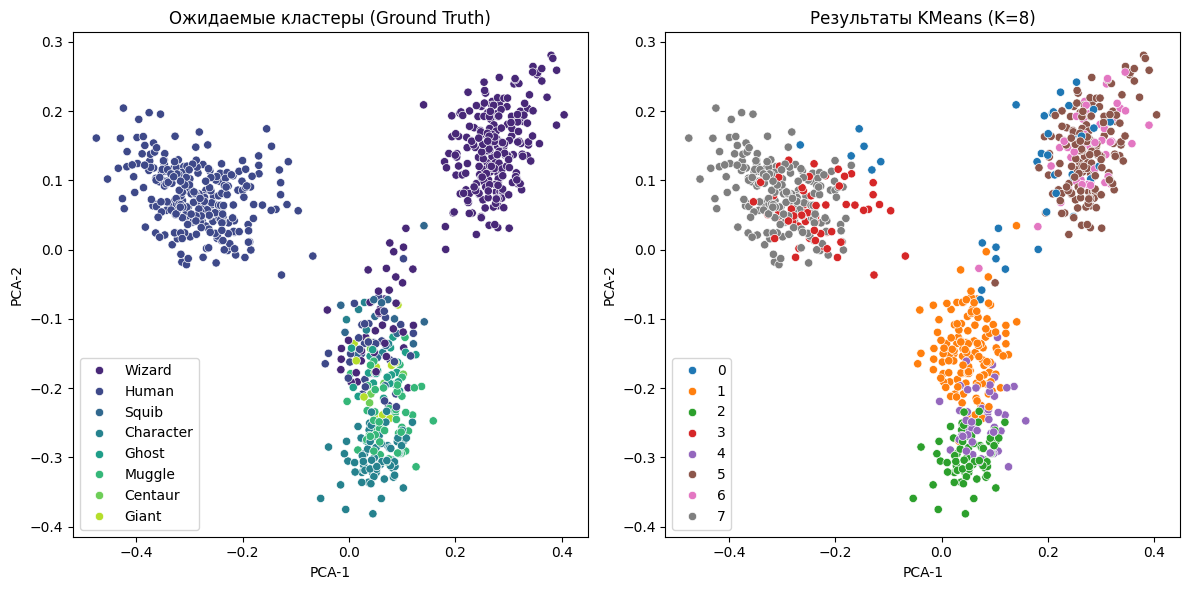


Adjusted Rand Score (Ground Truth Wizard/Non-Wizard vs KMeans): 0.2471


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from rdflib.namespace import RDF
from rdflib import URIRef

if 'ALL_FACTORY' not in globals() or 'model' not in globals() or 'g' not in globals():
    raise NameError("Критические переменные (ALL_FACTORY, model, g) не найдены. Убедитесь, что нужная ячейка выполнена.")

entity_ids = torch.tensor(list(ALL_FACTORY.entity_to_id.values()), dtype=torch.long)
all_entity_embeddings = model.entity_representations[0](indices=entity_ids).detach().cpu().numpy()

id_to_entity = {v: k for k, v in ALL_FACTORY.entity_to_id.items()}
entity_to_embedding = {id_to_entity[i]: all_entity_embeddings[i] for i in entity_ids.tolist()}

all_entity_types = {}
BASE_IRI = "http://www.semanticweb.org/ekaterinakulesova/ontologies/2025/0/harry_potter#"

def qn_clean(term):
    if isinstance(term, URIRef):
        term_str = str(term)
        if term_str.startswith(BASE_IRI):
            return "hpo:" + term_str.split("#")[-1]
        for prefix, uri in g.namespaces():
            if term_str.startswith(uri):
                return f"{prefix}:{term_str[len(uri):].replace('#', '')}"
        return term_str
    return str(term)

for s, p, o in g.triples((None, RDF.type, None)):
    s_clean = qn_clean(s)
    o_clean = qn_clean(o)
    if s_clean.startswith("hpo:"):
        if s_clean not in all_entity_types:
            all_entity_types[s_clean] = set()
        all_entity_types[s_clean].add(o_clean.replace("hpo:", ""))

PRIORITY = {
    "Wizard": 5, "Muggle": 4, "Squib": 3,
    "Centaur": 3, "Ghost": 3, "Giant": 3, "House_elf": 3, "Mermaid": 3,
    "Magical_creature": 2,
    "Human": 1,
    "Character": 0
}

entity_type_map = {}
for entity, types in all_entity_types.items():
    best_type = "Non_Character"
    max_priority = -2

    for t in types:
        prio = PRIORITY.get(t, -1) # -1 для типов, которые не в списке (например, Artifact, Location)

        if prio > max_priority:
            max_priority = prio
            best_type = t

    if max_priority >= PRIORITY["Character"]:
        entity_type_map[entity] = best_type

valid_characters_set = {e for e in entity_type_map if entity_type_map[e] != "Non_Character" and e in entity_to_embedding}
valid_characters = list(valid_characters_set)

X = np.array([entity_to_embedding[e] for e in valid_characters])
labels_true_all = [entity_type_map[e] for e in valid_characters]

y_binary_for_ars = np.array([1 if l == "Wizard" else 0 for l in labels_true_all])

print(f"Общее количество персонажей для классификации: {len(X)}")
print(f"Распределение классов в labels_true: \n{pd.Series(labels_true_all).value_counts()}")

global character_embeddings, labels_true_all, valid_characters
character_embeddings = X
labels_true_all = labels_true_all
valid_characters = valid_characters


# снижение размерности
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels_true_all, palette='viridis', legend='full')
plt.title('Ожидаемые кластеры (Ground Truth)')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')

# Применение KMeans
k = len(set(labels_true_all))
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_pred, palette='tab10', legend='full')
plt.title(f'Результаты KMeans (K={k})')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.tight_layout()
plt.show()

ars = adjusted_rand_score(y_binary_for_ars, y_pred)
print(f"\nAdjusted Rand Score (Ground Truth Wizard/Non-Wizard vs KMeans): {ars:.4f}")

Классификация.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Wizard 1 Non-Wizard 0
X = character_embeddings
y_binary = np.array([1 if l == "Wizard" else 0 for l in labels_true_all])

print(f"Распределение классов (0:Non-Wizard, 1:Wizard) в полном наборе: {pd.Series(y_binary).value_counts()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print(f"Размер обучающей выборки (Train/Test): {len(X_train)} / {len(X_test)}")

# применение модели классификации (Logistic Regression)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)
y_pred_kge = clf.predict(X_test)
accuracy_kge = accuracy_score(y_test, y_pred_kge)

print("\n--- Оценка Классификации (Wizard/Non-Wizard) ---")
print(f"Точность модели KGE-embeddings: {accuracy_kge:.4f}")


#модель 1: выдает наиболее часто встречающийся класс
majority_class = pd.Series(y_train).mode()[0]
y_base1_pred = np.full_like(y_test, majority_class)
accuracy_base1 = accuracy_score(y_test, y_base1_pred)
print(f"Точность базовой модели (Majority Class {majority_class}): {accuracy_base1:.4f}")

# модель 2: One-Hot Encoding Representation
ohe_data = pd.get_dummies(pd.Series(valid_characters))
X_ohe = ohe_data.values

# Выполняем тот же сплит на OHE-данных
X_ohe_train, X_ohe_test, _, _ = train_test_split(
    X_ohe, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

# Обучение на OHE
clf_ohe = LogisticRegression(random_state=42, max_iter=1000)
clf_ohe.fit(X_ohe_train, y_train)
y_pred_ohe = clf_ohe.predict(X_ohe_test)
accuracy_base2 = accuracy_score(y_test, y_pred_ohe)
print(f"Точность базовой модели (One-Hot Encoding): {accuracy_base2:.4f}")

# Вывод
improvement = accuracy_kge - accuracy_base2
print(f"\nВывод: Точность улучшилась на {improvement:.4f} по сравнению с OHE.")

Распределение классов (0:Non-Wizard, 1:Wizard) в полном наборе: 0    495
1    267
Name: count, dtype: int64
Размер обучающей выборки (Train/Test): 609 / 153

--- Оценка Классификации (Wizard/Non-Wizard) ---
Точность модели KGE-embeddings: 0.9477
Точность базовой модели (Majority Class 0): 0.6471
Точность базовой модели (One-Hot Encoding): 0.6471

Вывод: Точность улучшилась на 0.3007 по сравнению с OHE.


Предсказание недостающих ссылок
Цель: Использовать KGE-модель для оценки ее способности предсказывать недостающие триплеты в оригинальной тестовой выборке (test_kg_df - 20% всех триплетов).

In [ ]:
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch

testing_factory = TriplesFactory.from_labeled_triples(
    triples=test_kg_df.values,
    entity_to_id=ALL_FACTORY.entity_to_id,
    relation_to_id=ALL_FACTORY.relation_to_id,
    create_inverse_triples=True # Должно соответствовать настройкам обучения
)

# Выполнение оценки (предсказание и ранжирование)
evaluator = RankBasedEvaluator()
metric_results = evaluator.evaluate(
    model=model,
    mapped_triples=testing_factory.mapped_triples,
    additional_filter_triples=[training_data_factory.mapped_triples],
    batch_size=256,
)

print("\n--- Оценка на финальной Тестовой Выборке (Link Prediction) ---")

# количественная оценка (MRR, Hits@10)
flat_metrics = metric_results.to_flat_dict()
MR_KEY = 'both.realistic.arithmetic_mean_rank'
MRR_KEY = 'both.realistic.inverse_harmonic_mean_rank'
HITS10_KEY = 'both.realistic.hits_at_10'

try:
    #print(f"MR (Mean Rank) на Test Set: {flat_metrics[MR_KEY]:.2f}")
    print(f"MRR (Mean Reciprocal Rank) на Test Set: {flat_metrics[MRR_KEY]:.4f}")
    print(f"Hits@10 на Test Set: {flat_metrics[HITS10_KEY]:.4f}")
except KeyError as e:
     print(f"Ошибка: Не удалось найти метрику по ключу: {e}. Проверьте правильность ключей.")

Evaluating on cpu:   0%|          | 0.00/370 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.21s seconds



--- Оценка на финальной Тестовой Выборке (Link Prediction) ---
MRR (Mean Reciprocal Rank) на Test Set: 0.1171
Hits@10 на Test Set: 0.3905
